In [53]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.densenet import DenseNet121
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.models import Model
# from keras import backend as K
# from keras.models import load_model
# import util
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]


## Data Exploration

In [55]:
train_df = pd.read_csv("train-small.csv")
valid_df = pd.read_csv("valid-small.csv")
test_df = pd.read_csv("test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 1000 rows and 16 columns in the train data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [56]:
print(f"Train set: The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]}")
print(f"Validation set: The total patient ids are {valid_df['PatientId'].count()}")
print(f"Test set: The total patients ids are {test_df['PatientId'].count()}")

Train set: The total patient ids are 1000, from those the unique ids are 928
Validation set: The total patient ids are 200
Test set: The total patients ids are 420


## Preventing Data leakage

It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [59]:
def check_for_leakage(df1, df2, patient_col):
    
    '''
    Return True if there any patients are in both df1 and df2
    Args:
    df1(dataframe): dataframe describing first dataset
    df2(dataframe): dataframe describing second dataset
    patient_col(str): string  name of column with patient IDs

    Returns:
    leakage(bool): True if there is leakage, otherwise False
    '''
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0
    return leakage
    

In [60]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


### Explore data labels

Create a list of names of each patient condition or disease

In [63]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [64]:
#Remove unnecessary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditios: {columns}")
# print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditios: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


## Data Visualization

using the image names listed in the csv file, retrieve the image associated with each row of data in your dataframe.

Display Random images


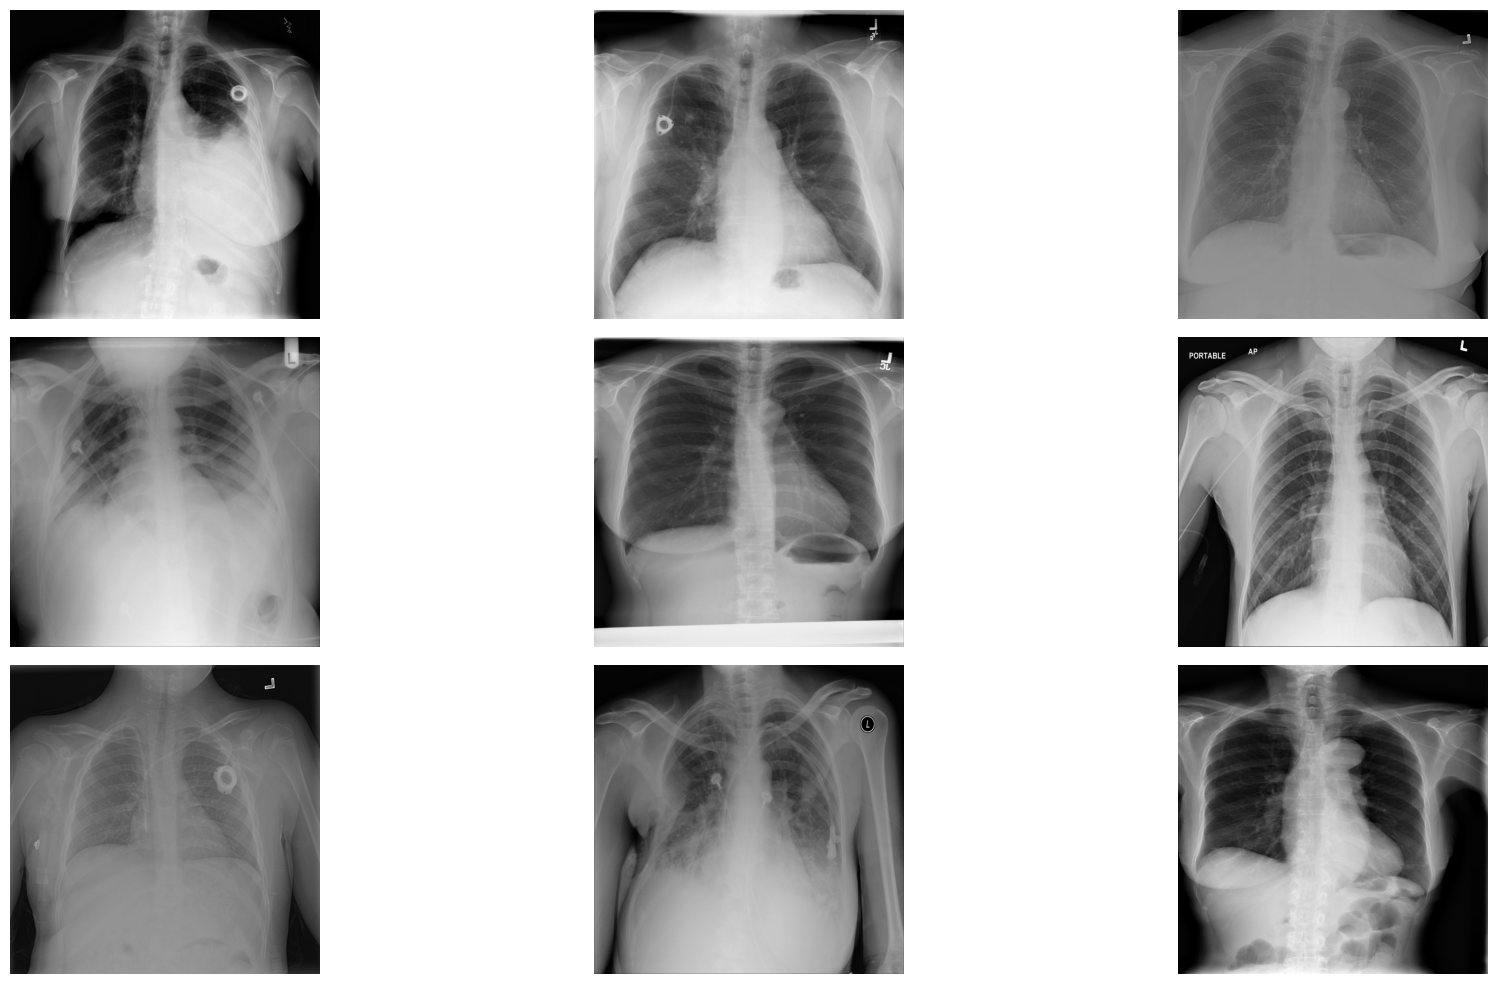

In [67]:
#Extract numpy values from images column in data frame
image =  train_df['Image'].values

#extract 9 random images from it
random_images = [np.random.choice(image) for i in range(9)]

img_dir = r'C:\Users\DeLL\Desktop\python files\Chest_Xray_medical\Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning-master\images\images'
print('Display Random images')

#adjust the size of image
plt.figure(figsize=(20,10))
#iterate and plot random images
for i in range(9):
     plt.subplot(3,3, i+1)
     img= plt.imread(os.path.join(img_dir, random_images[i]))
     plt.imshow(img, cmap = 'grey')
     plt.axis('off')

# adjust subplot parameters to give specified padding
plt.tight_layout()


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


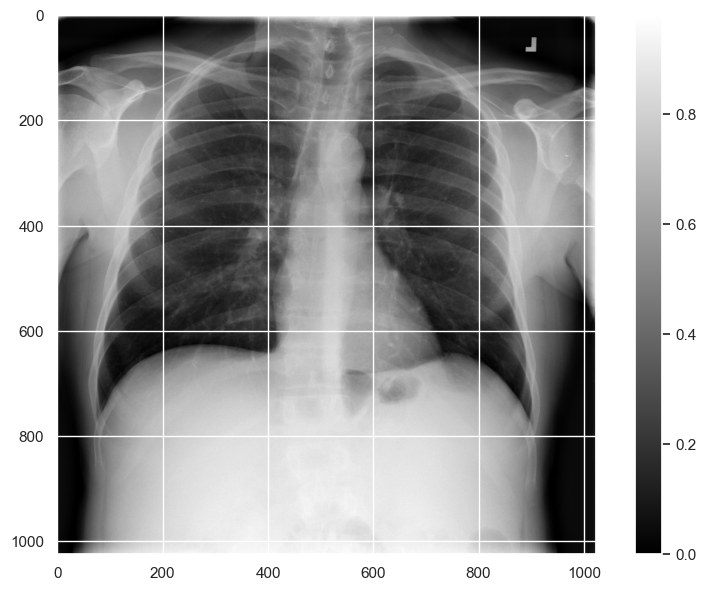

In [68]:
# get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='grey')
plt.grid(color = 'w', linestyle='-', linewidth=1)
plt.colorbar()
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution

plot up the distribution of pixel values in the image shown above

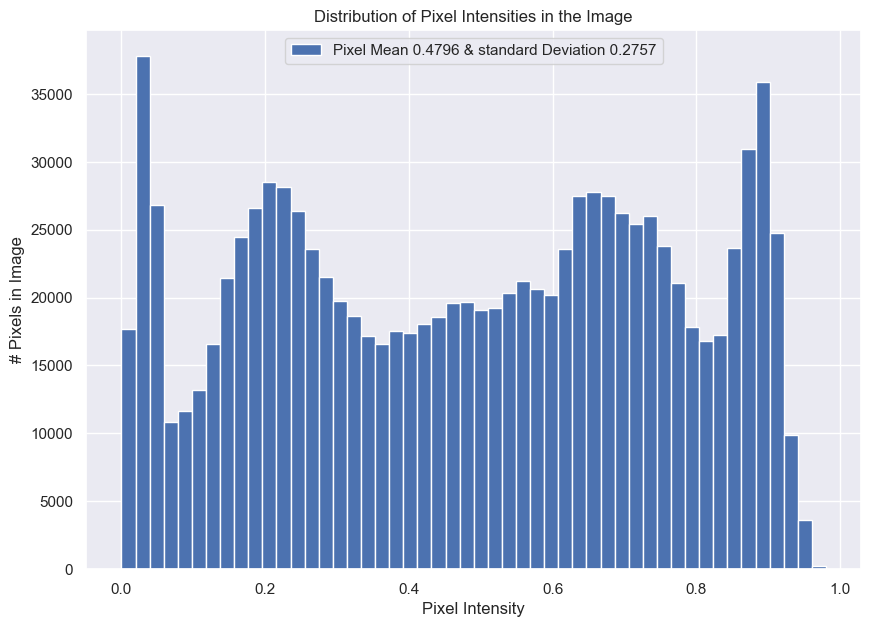

In [71]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins = 50, label=f'Pixel Mean {np.mean(raw_image):.4f} & standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

# Image preprocessing in keras

### standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation. The image_generator will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviati.
                            $$\frac{x_i - \mu}{\sigma}$$
Create an image generator for preprocessing. Pre-process the data using the image_generatoras well as reduce the image size down to 320x320 pixelson

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
def get_train_generator(df, image_dir, x_col,y_cols, shuffle = True, batch_size=8, seed=1, target_w = 320, target_h=320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    print("getting train generator...")
     # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center = True,              #set each sample mean to 0
        samplewise_std_normalization = True    # divide each input by its standard deviation
    )
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode = "raw",
        batch_size = batch_size,
        shuffle = shuffle,
        seed=seed,
        target_size = (target_w, target_h)
    )
    return generator

In [77]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = next(raw_train_generator) # generate a batch of samples and associated labels 
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [78]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = img_dir = r'C:\Users\DeLL\Desktop\python files\Chest_Xray_medical\Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning-master\images\images'
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 1000 validated image filenames.

getting valid generator...
Found 200 validated image filenames.

getting test generator...
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.8194 and the minimum is -3.4863
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


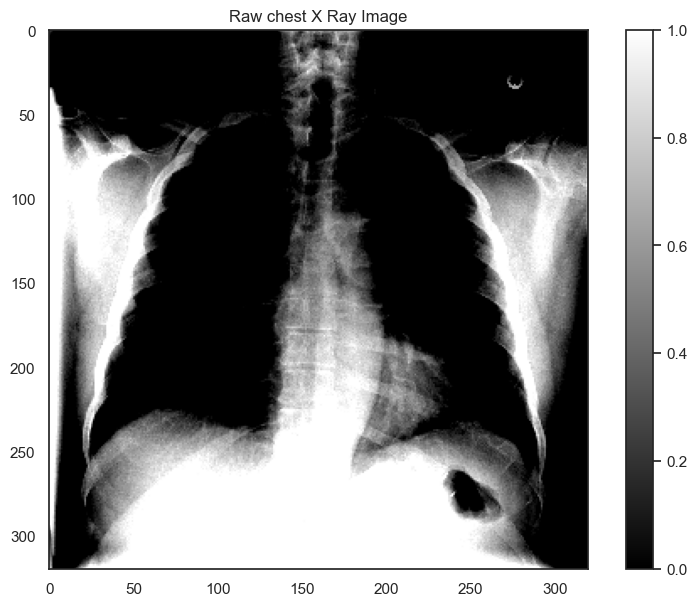

In [79]:
#plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='grey')
plt.colorbar()
plt.title('Raw chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [80]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


C:\Users\DeLL\AppData\Local\Temp\ipykernel_4416\1036713025.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
C:\Users\DeLL\AppData\Local\Temp\ipykernel_4416\1036713025.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


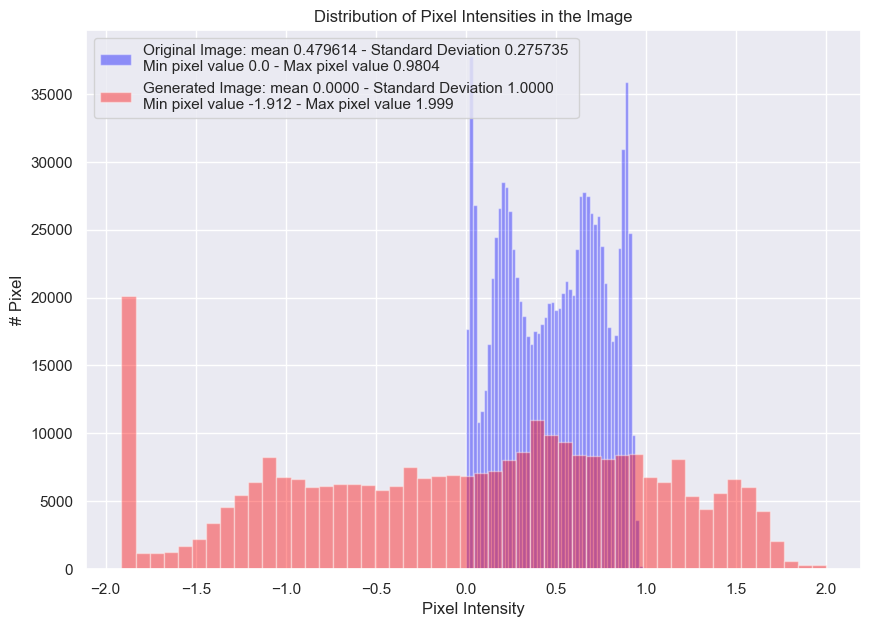

In [81]:
#Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

#plot histogram for original image
sns.distplot(raw_image.ravel(),
            label=f'Original Image: mean {np.mean(raw_image):4f} - Standard Deviation {np.std(raw_image):4f} \n'
            f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
            color='blue',
            kde=False)

#plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
            label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

#place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()


## Addressing Class Imbalance - Weighted Loss

one of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. let's plot the frequency of each of the labels in our datasets.

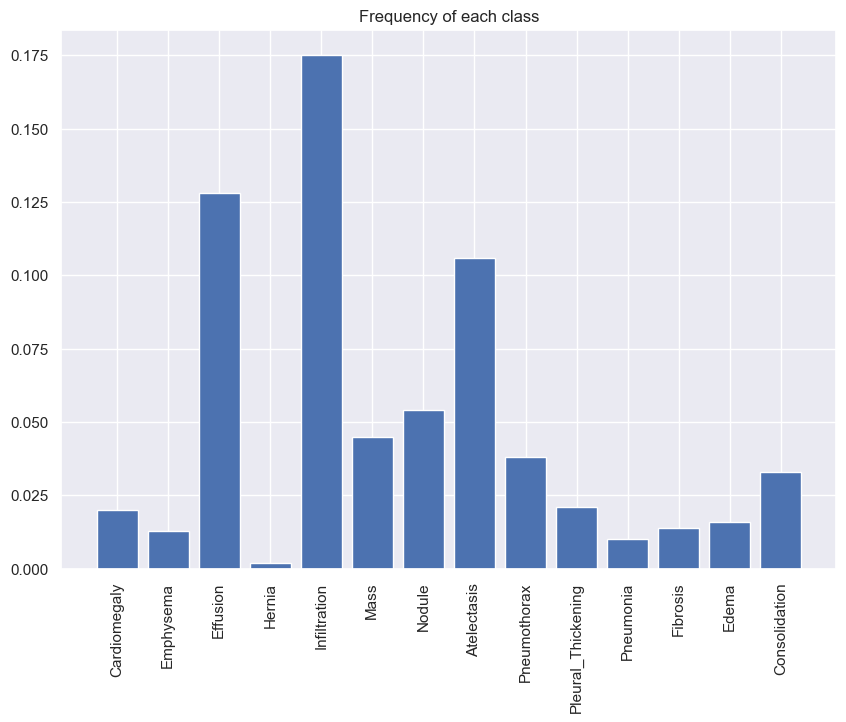

In [84]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of each class")
plt.show()

### Computing Class Frequencies

In [86]:
def compute_class_freqs(labels):
    '''
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    '''
    # total number of patients (rows)
    N=labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N    # broadcasting of N to a line vector of dim num_classes
    return positive_frequencies, negative_frequencies

In [87]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

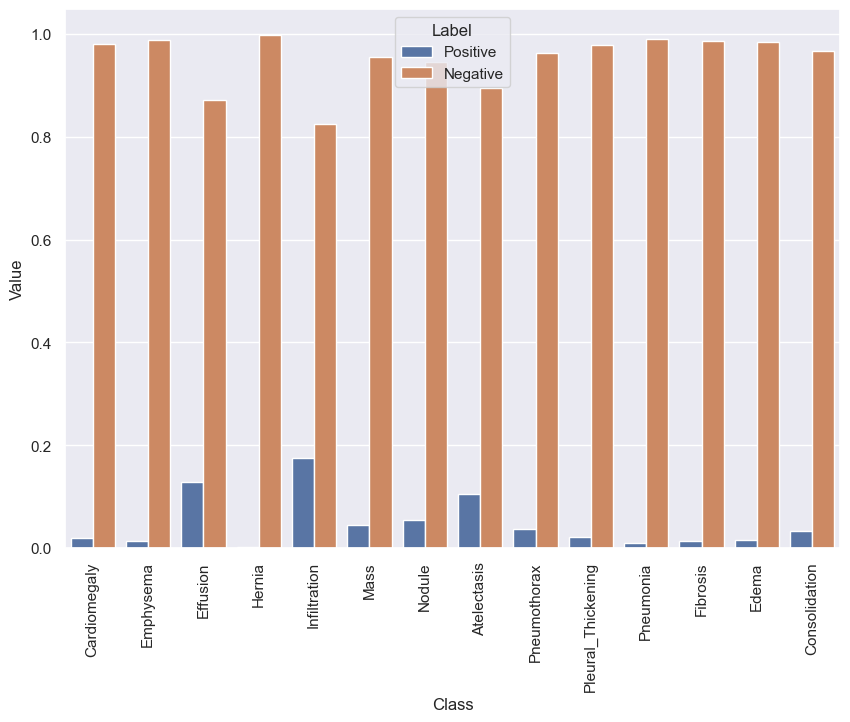

In [88]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Use pd.concat instead of append
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])
data = pd.concat([data, new_data], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)


In [89]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

<Axes: xlabel='Class', ylabel='Value'>

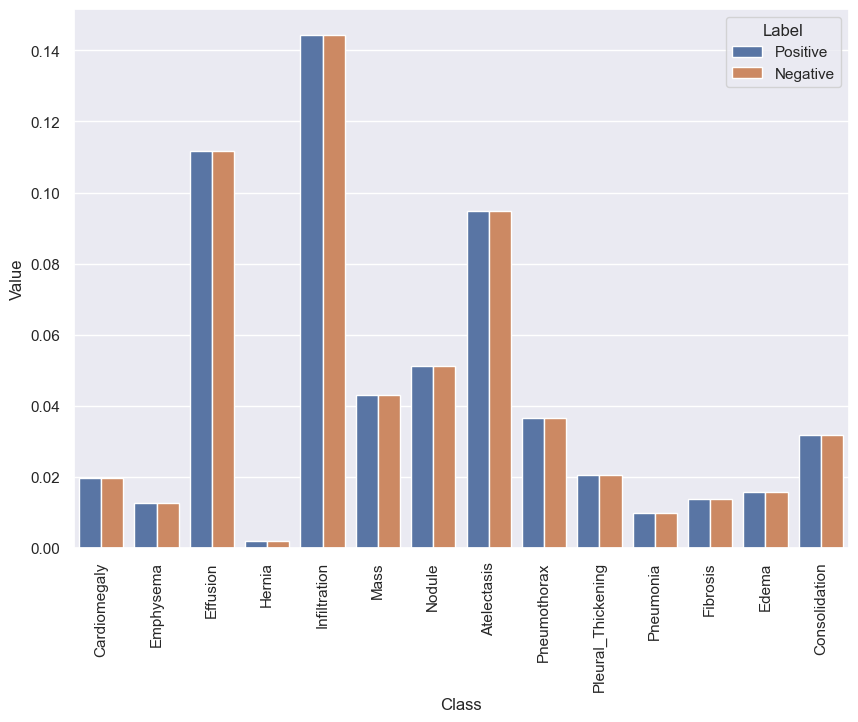

In [90]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Replace append with pd.concat
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])
data = pd.concat([data, new_data], ignore_index=True)

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)


## Weighted Loss

In [92]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss             # this is a function taking 2 arguments y_true and y_pred

### DenseNet121

In [94]:
import keras
import tensorflow
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau,EarlyStopping, TensorBoard
from keras.preprocessing import image

In [95]:
def load_model():
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df)- class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos/class_total
    neg_weights = class_neg/ class_total
    print("Got loss weights" )
    # create the base pre-trained model
    base_model = DenseNet121(weights = 'densenet.hdf5' , include_top = False)
    print("Loaded Densenet")
    # add a gloabl spatial average pooling layer
    x= base_model.output
    x= GlobalAveragePooling2D()(x)
    # and a LOGISTIC LAYER
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("C:/Users/DeLL/Desktop/python files/Chest_Xray_medical/Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning-master/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [96]:
model = load_model()

Got loss weights
Loaded Densenet
Added layers
Compiled Model
Loaded Weights


In [97]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_6              │ (None, None, None, 3)     │               0 │ input_layer_3[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,408 │ zero_padding2d_6[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_7              │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, None, None, 64)    │               0 │ zero_padding2d_7[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, None, None, 64)    │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 128)   │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 128)   │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 128)   │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 32)    │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, None, None, 96)    │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [98]:
layers_ = model.layers
print('total number of layers = ',len(layers_))

total number of layers =  429


In [99]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [100]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

Model input --------------> <KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor_1287>
Feature extractor output -> <KerasTensor shape=(None, None, None, 1024), dtype=float32, sparse=False, name=keras_tensor_1711>
Model output -------------> <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_1715>


### Training

In [102]:
# from tensorflow.keras import backend as K
# history = model.fit(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               epochs = 1)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

### Prediction and Evaluation

In [104]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

C:\Users\DeLL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 725ms/step


(420, 14)

### ROC Curve and AUROC

In [106]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

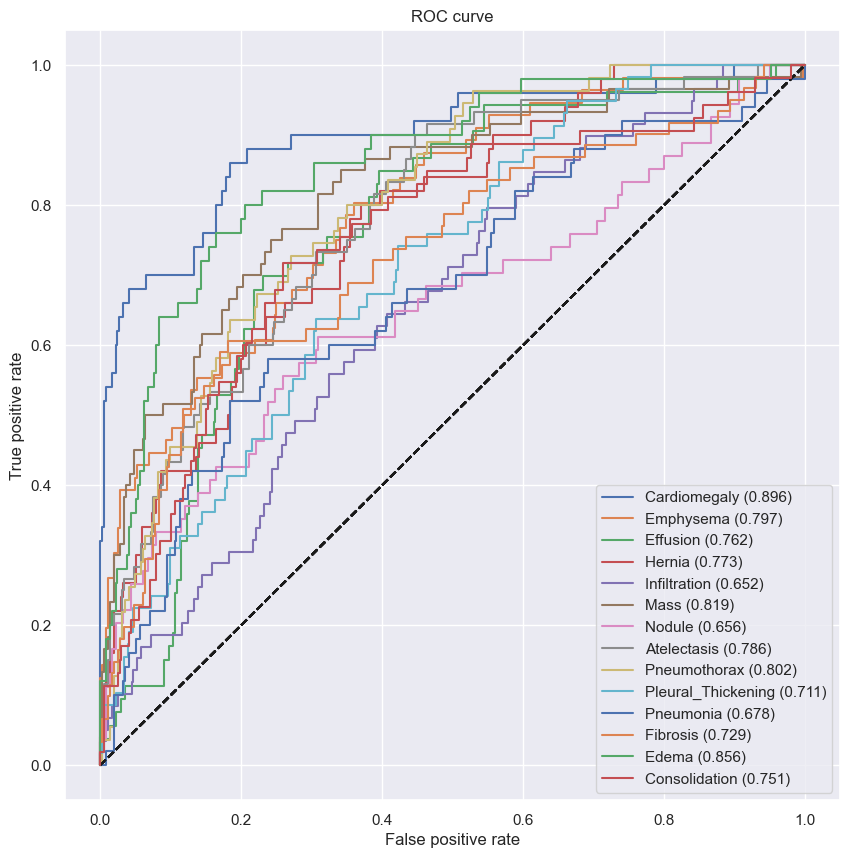

In [107]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [108]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [0.8959459459459459, 0.7965561224489797, 0.7616574983291349, 0.7732432432432432, 0.6518615897459975, 0.8189351851851852, 0.6556871078729002, 0.7856018518518519, 0.8020423412204234, 0.711278338731187, 0.6780540540540541, 0.7285264167313577, 0.8559459459459459, 0.7513752506297877] 
 for all 14 classes


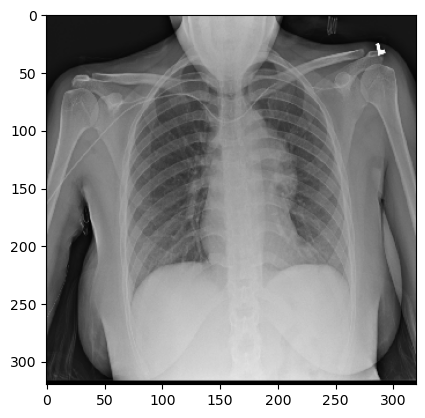

In [109]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR + '\\00025288_001.png' 
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR + '\\00025288_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [110]:
mean, std = get_mean_std_per_batch(train_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


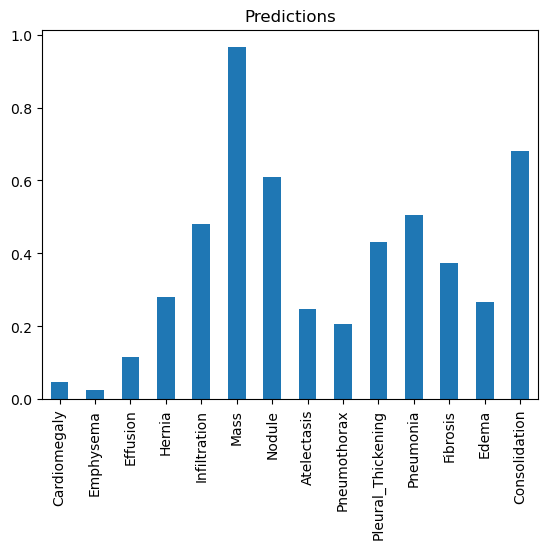

In [111]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [112]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.047542,0.024683,0.114665,0.27984,0.481536,0.965896,0.60837,0.248116,0.207372,0.431863,0.504938,0.37293,0.265591,0.681069
